In [1]:
from cv2 import aruco as aruco
from pathlib import Path

import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np

In [2]:
SQUARE_LENGTH = 0.0525
MARKER_LENGTH = 0.0310
SQUARE_X = 5
SQUARE_Y = 7

dictionary = aruco.getPredefinedDictionary(aruco.DICT_6X6_50)
board = aruco.CharucoBoard(
    (SQUARE_X, SQUARE_Y), SQUARE_LENGTH, MARKER_LENGTH, dictionary)

charuco_params = aruco.CharucoParameters()
charuco_params.tryRefineMarkers = False
detector_params = aruco.DetectorParameters()
detector = aruco.CharucoDetector(board, charuco_params, detector_params)

In [3]:
image_set = "set0"
l_calib_files = sorted(Path(f"captures/{image_set}/calib/front").glob('*.JPG'))
r_calib_files = sorted(Path(f"captures/{image_set}/calib/right").glob('*.JPG'))

l_calib_images = [cv.imread(str(file)) for file in l_calib_files]
r_calib_images = [cv.imread(str(file)) for file in r_calib_files]

In [4]:
def match_stereo_charuco(
    l_images: list[np.array], 
    r_images: list[np.array],
    detector: aruco.CharucoDetector
) -> tuple[list[np.array], list[np.array], list[np.array], np.array]:
    all_obj_points = []
    all_l_img_points = []
    all_r_img_points = []
    all_l_corners = []
    all_r_corners = []
    included_mask = np.ones(len(l_images), dtype=bool)

    for i, (l_image, r_image) in enumerate(zip(l_images, r_images)):
        l_corners, l_ids, _, _ = detector.detectBoard(l_image)
        r_corners, r_ids, _, _ = detector.detectBoard(r_image)

        if l_ids is None or r_ids is None:
            included_mask[i] = 0
            continue

        # Find common IDs
        common_ids = set(l_ids.flatten()).intersection(set(r_ids.flatten()))
        if not common_ids:
            included_mask[i] = 0
            continue

        # Filter out corners that are common in both images
        l_common = np.isin(l_ids.flatten(), list(common_ids), True)
        r_common = np.isin(r_ids.flatten(), list(common_ids), True)

        l_corners = l_corners[l_common]
        r_corners = r_corners[r_common]
        ids = l_ids[l_common]

        board = detector.getBoard()
        obj_points, l_img_points = board.matchImagePoints(l_corners, ids)
        _, r_img_points = board.matchImagePoints(r_corners, ids)

        all_obj_points.append(obj_points)
        all_l_img_points.append(l_img_points)
        all_r_img_points.append(r_img_points)
        all_l_corners.append(l_corners)
        all_r_corners.append(r_corners)
        
    return all_obj_points, all_l_img_points, all_r_img_points, all_l_corners, all_r_corners, included_mask.astype(bool)

In [5]:
obj_points, l_img_points, r_img_points, l_corners, r_corners, included = match_stereo_charuco(
    l_calib_images, r_calib_images, detector)

In [6]:
_COLORS = [
    (255, 0, 0),      # Red
    (0, 255, 0),      # Green
    (0, 0, 255),      # Blue
    (255, 255, 0),    # Yellow
    (255, 0, 255),    # Magenta
    (0, 255, 255),    # Cyan
    (128, 0, 0),      # Maroon
    (0, 128, 0),      # Dark Green
    (0, 0, 128),      # Navy
    (128, 128, 0),    # Olive
    (128, 0, 128),    # Purple
    (0, 128, 128),    # Teal
    (192, 192, 192),  # Silver
    (128, 128, 128),  # Gray
    (255, 165, 0),    # Orange
    (255, 20, 147),   # Deep Pink
    (75, 0, 130),     # Indigo
    (255, 192, 203),  # Pink
]

def draw_stereo_matching(l_images, r_images, l_corners, r_corners, radius=10):
    l_drawings = []
    r_drawings = []

    for l_image, r_image, l_points, r_points in zip(l_images, r_images, l_corners, r_corners):
        n_colors = len(_COLORS)

        l_drawing = np.copy(l_image)
        r_drawing = np.copy(r_image)

        for i, point in enumerate(l_points):
            point = point.astype(int)
            cv.circle(l_drawing, point, radius, _COLORS[i % n_colors], -1)

        for i, point in enumerate(r_points):
            point = point.astype(int)
            cv.circle(r_drawing, point, radius, _COLORS[i % n_colors], -1)

        l_drawings.append(l_drawing)
        r_drawings.append(r_drawing)

    return l_drawings, r_drawings

In [7]:
l_calib_images_included = np.array(l_calib_images)[included]
r_calib_images_included = np.array(r_calib_images)[included]
l_corners_flattened = [corners.reshape(-1, 2) for corners in l_corners]
r_corners_flattened = [corners.reshape(-1, 2) for corners in r_corners]
l_charuco_matches, r_charuco_matches = draw_stereo_matching(
    l_calib_images_included, r_calib_images_included, l_corners_flattened, r_corners_flattened, radius=40)

In [8]:
def plot_image_pairs(images_1, images_2, fig_size=(10, 20)):
    n_images = len(images_1)
    _, axes = plt.subplots(n_images, 2, figsize=fig_size)

    if n_images == 1:
        axes = np.array([axes])

    for i, (image_1, image_2) in enumerate(zip(images_1, images_2)):
        # Display the images in the subplots
        axes[i, 0].imshow(np.flip(image_1, axis=2))
        axes[i, 1].imshow(np.flip(image_2, axis=2))

    # Hide the axes
    for ax in axes.flatten():
        ax.axis('off')

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

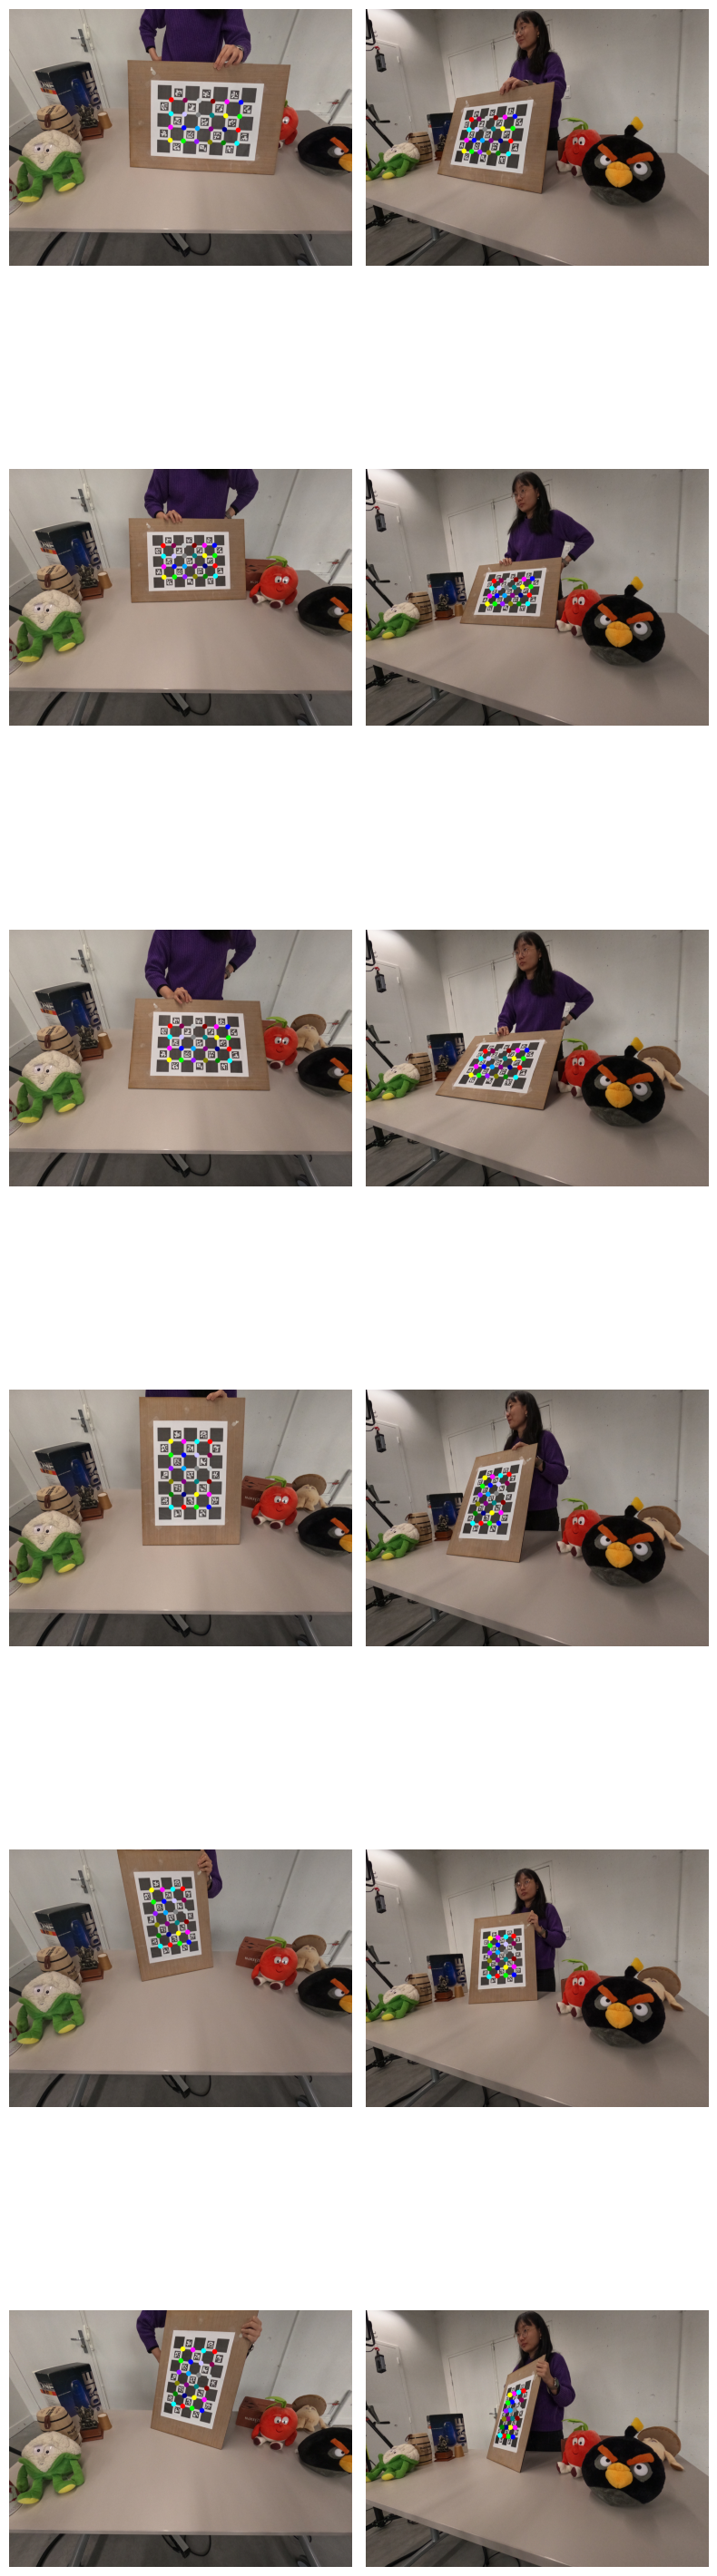

In [9]:
plot_image_pairs(l_charuco_matches, r_charuco_matches, (8, 32))

In [10]:
ORIGIN_SIZE = (5568, 4176)

In [11]:
l_ret_error, l_mtx, l_dist, _, _ = cv.calibrateCamera(obj_points, l_img_points, ORIGIN_SIZE, None, None)

print(f"Intrinsic parameters:")
print(l_mtx)
print(f"Distortion coefficients:")
print(l_dist)
print(f"Reprojection error:")
print(l_ret_error)

Intrinsic parameters:
[[2.58031120e+03 0.00000000e+00 2.79257738e+03]
 [0.00000000e+00 2.58008861e+03 2.06659038e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Distortion coefficients:
[[-0.01583483 -0.0001337  -0.00314833  0.00067826  0.01776014]]
Reprojection error:
0.4129558978996722


In [12]:
# So far haven't used
l_cam_mtx, l_roi = cv.getOptimalNewCameraMatrix(l_mtx, l_dist, ORIGIN_SIZE, 1, ORIGIN_SIZE)
print(f"New camera matrix:")
print(l_cam_mtx)
print(f"ROI:")
print(l_roi)

New camera matrix:
[[2.60163197e+03 0.00000000e+00 2.79694864e+03]
 [0.00000000e+00 2.56553664e+03 2.05082122e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
ROI:
(124, 115, 5322, 3943)


In [13]:
r_ret_error, r_mtx, r_dist, _, _ = cv.calibrateCamera(obj_points, r_img_points, ORIGIN_SIZE, None, None)

print(f"Intrinsic parameters:")
print(r_mtx)
print(f"Distortion coefficients:")
print(r_dist)
print(f"Reprojection error:")
print(r_ret_error)

Intrinsic parameters:
[[2.65735008e+03 0.00000000e+00 2.78569731e+03]
 [0.00000000e+00 2.64582452e+03 2.12038294e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Distortion coefficients:
[[ 0.09181201 -0.50758929  0.01164579  0.01180465  0.9895855 ]]
Reprojection error:
0.49013312384108126


In [14]:
# So far haven't used
r_cam_mtx, r_roi = cv.getOptimalNewCameraMatrix(r_mtx, r_dist, ORIGIN_SIZE, 1, ORIGIN_SIZE)
print(f"New camera matrix:")
print(r_cam_mtx)
print(f"ROI:")
print(r_roi)

New camera matrix:
[[3.76187202e+03 0.00000000e+00 2.83390121e+03]
 [0.00000000e+00 2.81461884e+03 2.14450369e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
ROI:
(1962, 1655, 1689, 956)


In [15]:
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)
flags = cv.CALIB_FIX_INTRINSIC
ret_error, _, _, _, _, l_R, l_t, l_E, l_F = cv.stereoCalibrate(
    obj_points, l_img_points, r_img_points, l_mtx, l_dist, r_mtx, r_dist, ORIGIN_SIZE, flags=flags, criteria=criteria)

print("Fundamental matrix:")
print(l_F)
print("Essential matrix:")
print(l_E)
print("Rotation matrix:")
print(l_R)
print("Translation vector:")
print(l_t)
print("Reprojection error (px):")
print(ret_error)

Fundamental matrix:
[[-6.15978969e-08  7.27015759e-08  4.69642739e-04]
 [ 1.13909728e-08  1.53621289e-07 -1.17579601e-03]
 [-1.98358362e-04  3.12718939e-04  1.00000000e+00]]
Essential matrix:
[[ 0.10465458 -0.12350904 -0.29489844]
 [-0.01926928 -0.25984752  0.54185431]
 [ 0.22108861 -0.53763995 -0.14555678]]
Rotation matrix:
[[ 0.90322327 -0.17272423  0.39287919]
 [-0.01541848  0.90178694  0.43190576]
 [-0.42889391 -0.39616493  0.81185181]]
Translation vector:
[[-0.55111235]
 [-0.2353696 ]
 [ 0.24036078]]
Reprojection error (px):
1.0385067792286642


In [16]:
def draw_stereo_epilines(images_1, images_2, corners_1, epilines_2, radius=20, thickness=10):
    _, n_cols, _ = images_1[0].shape
    n_colors = len(_COLORS)

    drawings_1 = []
    drawings_2 = []

    for image_1, image_2, points_1, lines_2 in zip(images_1, images_2, corners_1, epilines_2):
        drawing_1 = np.copy(image_1)
        drawing_2 = np.copy(image_2)

        for i, point in enumerate(points_1):
            point = point.astype(int)
            color = _COLORS[i % n_colors]
            cv.circle(drawing_1, point, radius, color, thickness=-1)

        for i, line in enumerate(lines_2):
            x0, y0 = map(int, [0, -line[2] / line[1] ])
            x1 ,y1 = map(int, [n_cols, -(line[2] + line[0] * n_cols) / line[1]])
            color = _COLORS[i % n_colors]
            cv.line(drawing_2, (x0, y0), (x1, y1), color, thickness)

        drawings_1.append(drawing_1)
        drawings_2.append(drawing_2)

    return drawings_1, drawings_2

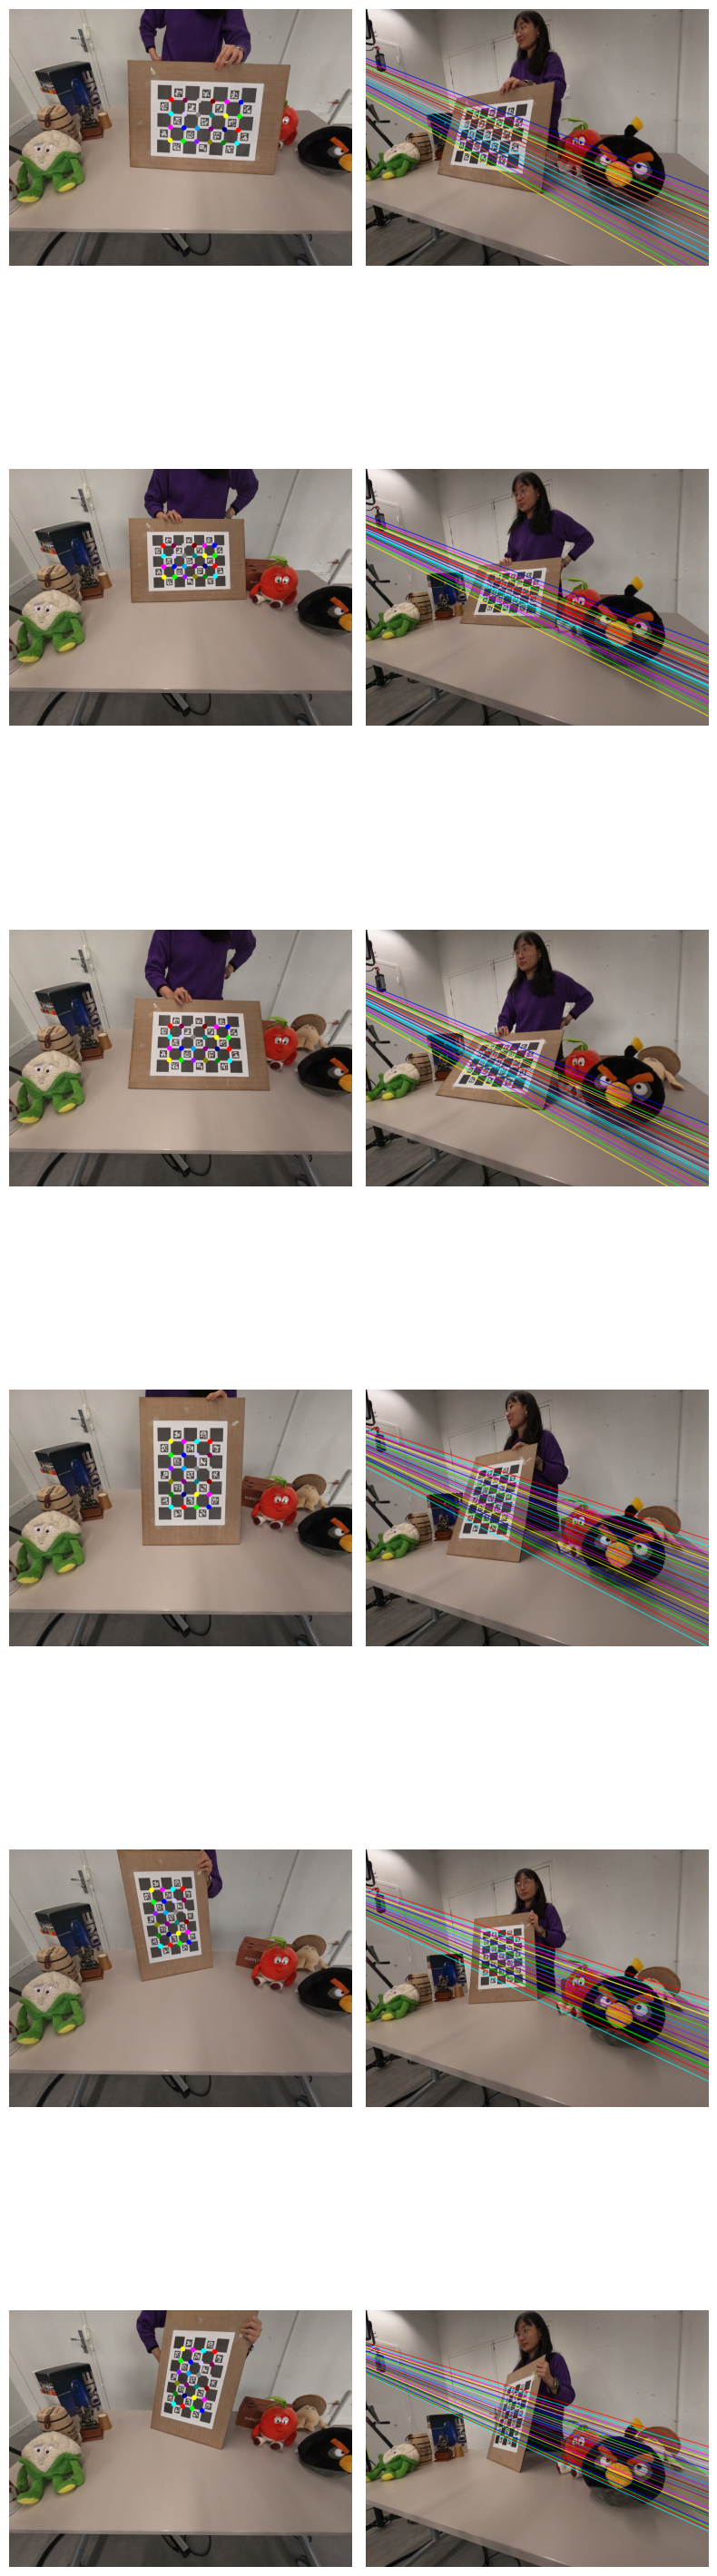

In [17]:
r_epilines = [cv.computeCorrespondEpilines(corners, whichImage=1, F=l_F) for corners in l_corners]
r_epilines_flattened = [lines.reshape(-1, 3) for lines in r_epilines]

l_epipoint_matches, r_epiline_matches = draw_stereo_epilines(
    l_calib_images_included, r_calib_images_included, l_corners_flattened, r_epilines_flattened, radius=40)
plot_image_pairs(l_epipoint_matches, r_epiline_matches, (8, 32))

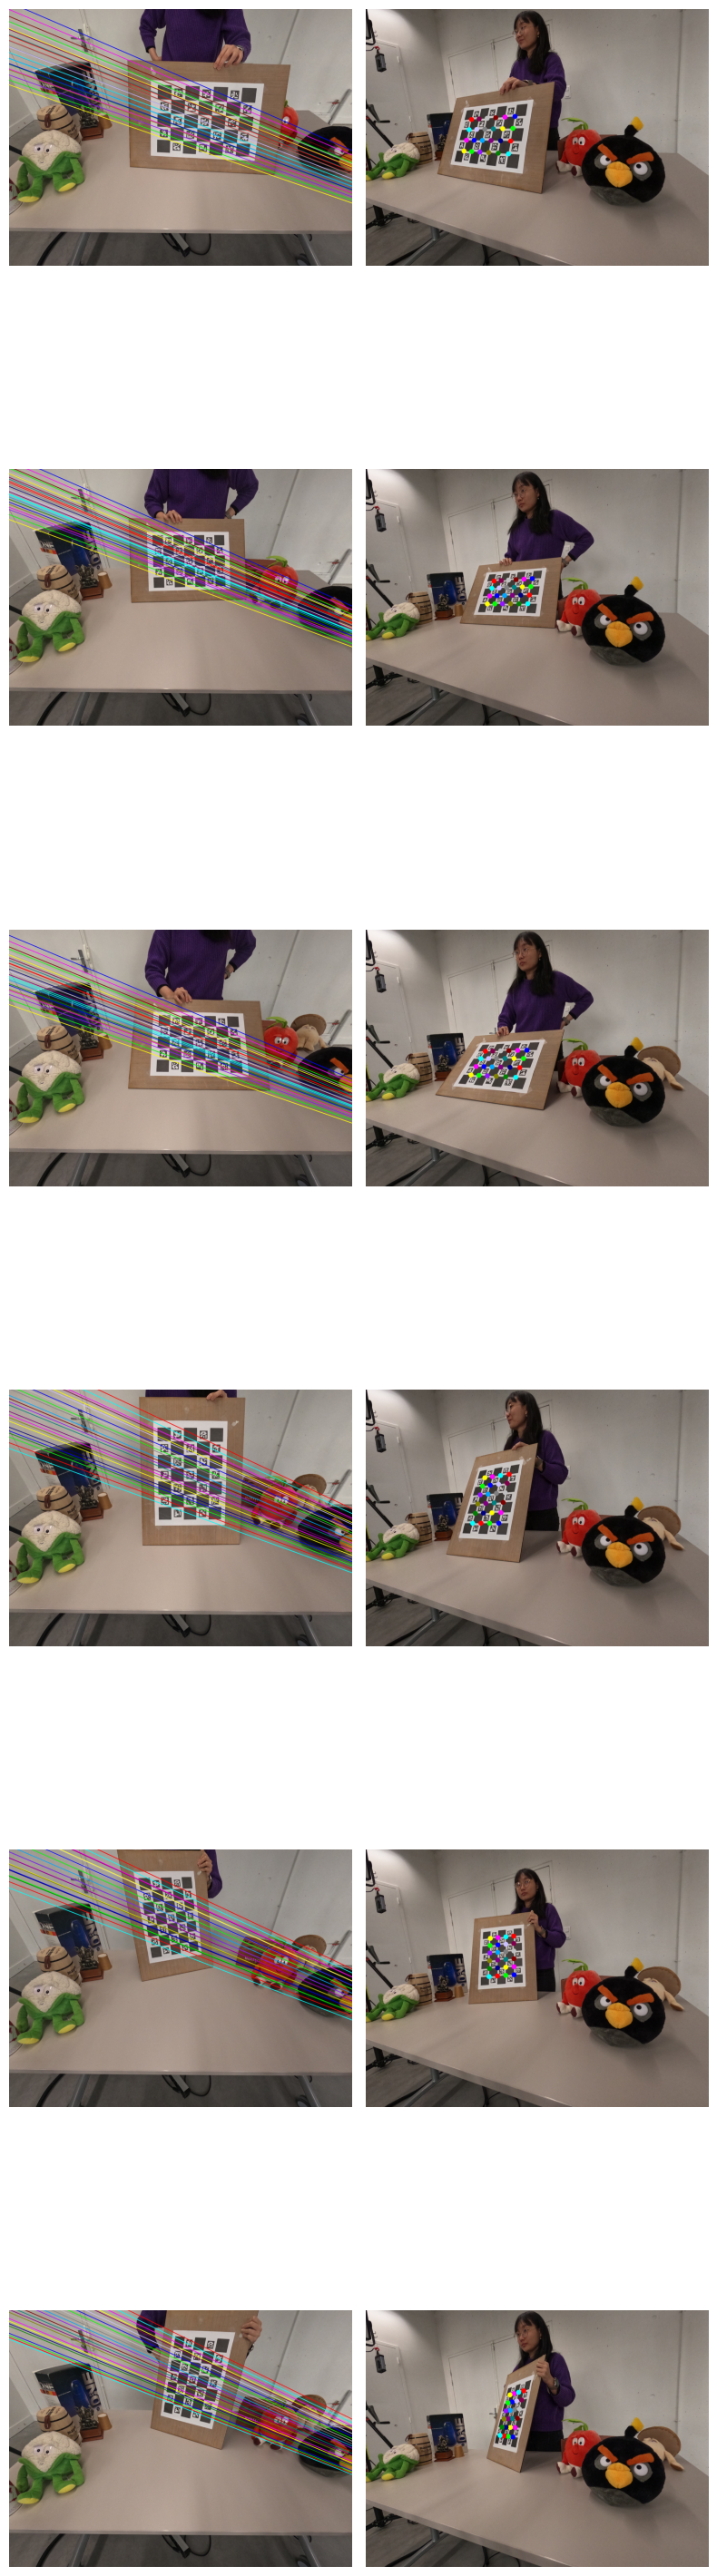

In [18]:
l_epilines = [cv.computeCorrespondEpilines(corners, whichImage=2, F=l_F) for corners in r_corners]
l_epilines_flattened = [lines.reshape(-1, 3) for lines in l_epilines]

r_epipoint_matches, l_epiline_matches = draw_stereo_epilines(
    r_calib_images_included, l_calib_images_included, r_corners_flattened, l_epilines_flattened, radius=40)
plot_image_pairs(l_epiline_matches, r_epipoint_matches, (8, 32))

In [19]:
l_rec_rotation, r_rec_rotation, l_rec_projection, r_rec_projection, l_Q, l_rec_roi, r_rec_roi = cv.stereoRectify(
    l_mtx, l_dist, r_mtx, r_dist, ORIGIN_SIZE, l_R, l_t)

In [20]:
l_stereo_map = cv.initUndistortRectifyMap(l_mtx, l_dist, l_rec_rotation, l_rec_projection, ORIGIN_SIZE, cv.CV_16SC2)
r_stereo_map = cv.initUndistortRectifyMap(r_mtx, r_dist, r_rec_rotation, r_rec_projection, ORIGIN_SIZE, cv.CV_16SC2)

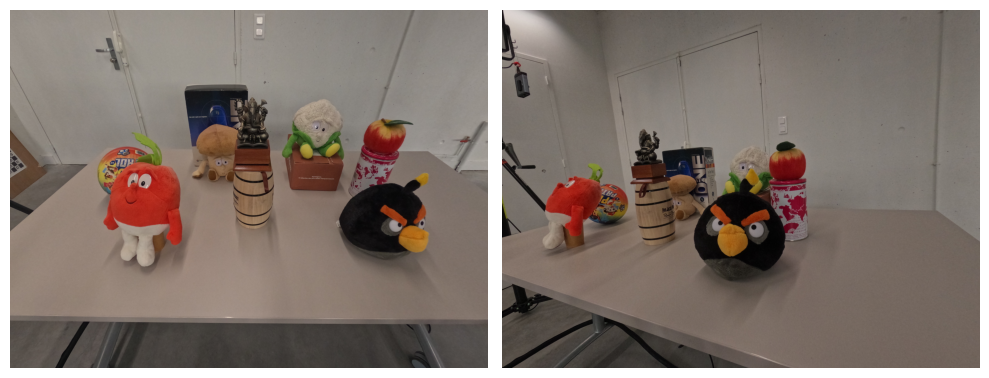

In [21]:
l_image = cv.imread(f"captures/{image_set}/front.JPG")
r_image = cv.imread(f"captures/{image_set}/right.JPG")

plot_image_pairs([l_image], [r_image])

In [22]:
def plot_gray_pairs(images_1, images_2, fig_size=(10, 20)):
    n_images = len(images_1)
    _, axes = plt.subplots(n_images, 2, figsize=fig_size)

    if n_images == 1:
        axes = np.array([axes])

    for i, (image_1, image_2) in enumerate(zip(images_1, images_2)):
    
        # Display the images in the subplots
        axes[i, 0].imshow(image_1, 'gray')
        # axes[2 * i].set_title('Match left')

        axes[i, 1].imshow(image_2, 'gray')
        # axes[2 * i + 1].set_title('Detection of ChArUco corners')

    # Hide the axes
    for ax in axes.flatten():
        ax.axis('off')

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

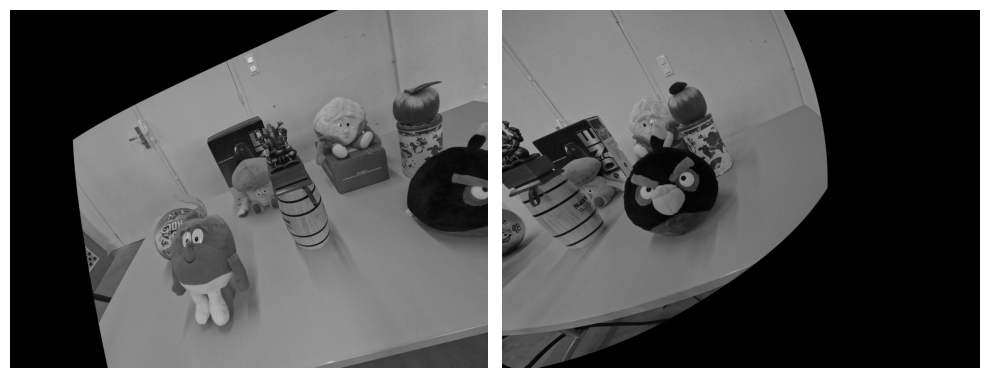

In [23]:
l_img_gray = cv.cvtColor(l_image, cv.COLOR_BGR2GRAY)
r_img_gray = cv.cvtColor(r_image, cv.COLOR_BGR2GRAY)

l_img_rectified = cv.remap(l_img_gray, l_stereo_map[0], l_stereo_map[1], cv.INTER_LANCZOS4, cv.BORDER_CONSTANT, 0)
r_img_rectified = cv.remap(r_img_gray, r_stereo_map[0], r_stereo_map[1], cv.INTER_LANCZOS4, cv.BORDER_CONSTANT, 0)

plot_gray_pairs([l_img_rectified], [r_img_rectified])

In [24]:
# So far haven't used
TARGET_SIZE = (2784, 2088)
l_img_downsampled = cv.resize(l_img_rectified, TARGET_SIZE)
r_img_downsampled = cv.resize(r_img_rectified, TARGET_SIZE)

In [25]:
# Set disparity parameters
win_size = 5
min_disp = -1
max_disp = 63                  # min_disp * 9
num_disp = max_disp - min_disp # must be divisible by 16

In [26]:
l_matcher = cv.StereoSGBM_create(
    minDisparity=min_disp,
	numDisparities=num_disp,
	blockSize=5,
	uniquenessRatio=5,
	speckleWindowSize=5,
	speckleRange=5,
	disp12MaxDiff=2,
	P1= 8 * 3 * win_size**2,
	P2=32 * 3 * win_size**2,
)
r_matcher = cv.ximgproc.createRightMatcher(l_matcher)



l_disparity = l_matcher.compute(l_img_rectified, r_img_rectified)
r_disparity = r_matcher.compute(r_img_rectified, l_img_rectified)

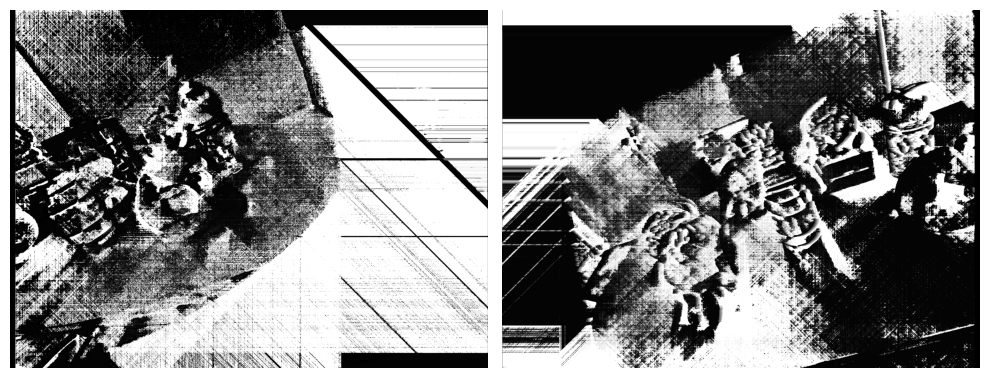

In [27]:
plot_gray_pairs([l_disparity], [r_disparity])

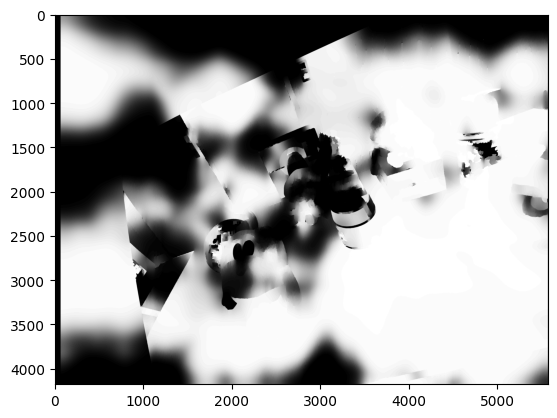

In [28]:
wls = cv.ximgproc.createDisparityWLSFilter(l_matcher)
wls.setLambda(8000)
wls.setSigmaColor(1.5)

disparity = wls.filter(l_disparity, l_img_rectified, disparity_map_right=r_disparity)
disparity, _ = cv.filterSpeckles(disparity, 0, 400, max_disp - 5)
_, disparity = cv.threshold(disparity, 0, max_disp * 16, cv.THRESH_TOZERO)
disparity = (disparity / 16).astype(np.uint8)
plt.imshow(disparity, 'gray')

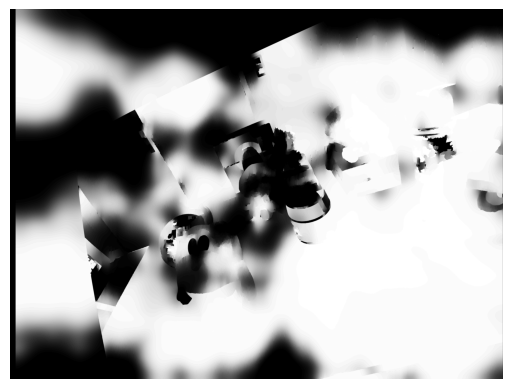

In [36]:
plt.axis('off')
plt.imshow(disparity, 'gray')

In [29]:
points = cv.reprojectImageTo3D(disparity, l_Q)
colors = cv.cvtColor(l_image, cv.COLOR_BGR2RGB)

points = points[disparity > np.min(disparity)]
colors = colors[disparity > np.min(disparity)]

In [30]:
points.shape

(19488026, 3)

In [31]:
def create_output(vertices, colors, filename):
	colors = colors.reshape(-1,3)
	vertices = np.hstack([vertices.reshape(-1, 3), colors])

	ply_header = '''ply
		format ascii 1.0
		element vertex %(vert_num)d
		property float x
		property float y
		property float z
		property uchar red
		property uchar green
		property uchar blue
		end_header
		'''
	with open(filename, 'w') as f:
		f.write(ply_header %dict(vert_num=len(vertices)))
		np.savetxt(f,vertices,'%f %f %f %d %d %d')

In [32]:
create_output(points, colors, "cloud.ply")

In [33]:
a = np.arange(4).reshape(2, 2)
for c in a:
    print(c)

print(a)

[0 1]
[2 3]
[[0 1]
 [2 3]]


In [34]:
a = [1, 2, 3, 4, 5]
a[0:4]

[1, 2, 3, 4]